## 1. Entendimento do problema de negócio

Vocé foi contratado(a) para uma consultoria, e seu trabalho envolve analisar os dados de preço do petróleo brent, que pode ser encontrado no site do ipea. Essa base de dados historica envolve duas colunas: data e preço (em dólares).
Um grande cliente do segmento pediu para que a consultoria desenvolvesse um dashboard interativo e que gere insights relevantes para tomada de decisão. Além disso, solicitaram que fosse desenvolvido um modelo de Machine Learning para fazer o forecasting do preço do petróleo.

Assim, o seu objetivo é:

1) Criar um dashboard interativo com ferramentas à sua escolha;<br><br>
2) Seu dashboard deve fazer parte de um storytelling que traga insights relevantes sobre a variacão do preco do petróleo, como situaõçes geopolíticas, crises econômicas, demanda global por energia e etc. Isso pode te ajudar com seu modelo - É obrigatörio que vocé traga pelo menos 4 insights neste desafio;<br><br>
3) Criar um modelo de Machine Learning que faca a previsão do preço do petróleo diariamente (lembre-se de time series). Esse modelo deve estar contemplado em seu storytelling e deve conter o código que vocé trabalhou, analisando as performances do modelo;<br><br>
4) Criar um plano para fazer o deploy em producäo do modelo, com as ferramentas que são necessárias; e<br><br>
5) Faca um MVP do seu modelo em producão utilizando o Streamlit.

## 2. Data Pré-processing

### 2.1. Load & Describe Data

#### 2.1.1. Requerimentos

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import locale
import plotly.graph_objects as go
import joblib

from datetime import datetime
from scipy.stats import trim_mean
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Prophet
from prophet import Prophet

# Para deep learning
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator

# Para machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#### 2.1.2. Import file

Realizamos um webscraping para buscarmos as informações tabulares do site imaginando que, caso tenhamos a necessidade de tornar essa busca atualizada diariamente poderemos apenas gerar automaticamente essa busca.

Webscraping com a biblioteca BeautifulSoup

In [2]:
# URL do site Ipeadata
url = "http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view"

# Fazendo a requisição para o site
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Encontrando os dados na página
dados = []
tabela = soup.find('table', {'id': 'grd_DXMainTable'})  # Identificando a tabela correta pelo ID
if tabela:
    for linha in tabela.find_all('tr'):
        colunas = linha.find_all('td')
        if len(colunas) == 2:  # Verificando se temos exatamente 2 colunas
            data = colunas[0].text.strip()
            preco = colunas[1].text.strip().replace(',', '.')
            dados.append([data, preco])

# Salvando os dados em um arquivo CSV
with open('preco_petroleo_brent_atualizado.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Data', 'Preço'])
    writer.writerows(dados)

print("Dados salvos com sucesso no arquivo 'preco_petroleo_brent_atualizado.csv'")


Dados salvos com sucesso no arquivo 'preco_petroleo_brent_atualizado.csv'


In [3]:
brent = pd.read_csv('preco_petroleo_brent_atualizado.csv')
brent.head()

,Data,Preço
0,Data,NaN
1,Preço - petróleo bruto - Brent (FOB),NaN
2,22/01/2024,81.70
3,19/01/2024,80.71
4,18/01/2024,81.04


#### 2.1.3. Analisando o shape do dataset

In [4]:
print(f'- O dataset possui {brent.shape[0]} linhas')
print(f'- O dataset possui {brent.shape[1]} colunas')

- O dataset possui 11094 linhas
- O dataset possui 2 colunas


#### 2.1.4. Levantando a lista das colunas

In [5]:
brent.columns

Index(['Data', 'Preço'], dtype='object')

#### 2.1.5. Informações do dataset

In [6]:
brent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11094 entries, 0 to 11093
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Data    11094 non-null  object 
 1   Preço   11092 non-null  float64
dtypes: float64(1), object(1)
memory usage: 173.5+ KB


Baseado nessa análise primária vimos que:

- o dataset possui 2 colunas e 11.080 linhas, mas como temos um dataframe que possui 2 colunas de "Data" e "Preço" e essas linhas do tipo float têm duas linhas a menos, consideramos que existem 2 linhas que não devem fazer parte do nosso df. Avaliando as primeiras 5 linhas vemos que foram inseridos os cabeçalhos de forma duplicada e 1 linha também com valores nulos. Iremos realizar o tratamento adequado na próxima sessão.

### 2.2. Data Cleansing & Feature Engineering

#### 2.2.1. Modificando os tipos dos dados

Como vimos anteriormente a coluna de data é do tipo float e, portanto, devemos alterar para o tipo data. Para que a conversão fosse realizada excluímos as duas primeiras linhas que apresentavam valores nulos.

In [7]:
petroleo_data_limpo = brent.drop([0, 1], axis=0)
petroleo_data_limpo['Data'] = pd.to_datetime(petroleo_data_limpo['Data'], format='%d/%m/%Y')
petroleo_data_limpo.head()

,Data,Preço
2,2024-01-22,81.70
3,2024-01-19,80.71
4,2024-01-18,81.04
5,2024-01-17,78.88
6,2024-01-16,80.15


In [8]:
petroleo_data_limpo.dtypes

Data     datetime64[ns]
Preço           float64
dtype: object

#### 2.2.2. Reload dataset

In [9]:
df = petroleo_data_limpo.copy()

In [10]:
df = df.reset_index(drop=True).sort_values(by="Data", ascending=False)

In [11]:
df.to_csv('brent_limpo.csv')

#### 2.2.3. Identify missing values

In [12]:
df.isna().values.any()

False

In [13]:
df.isna().sum()

Data     0
Preço    0
dtype: int64

#### 2.2.3. Identificando valores duplicados

In [14]:
df[df.duplicated()]

,Data,Preço


In [15]:
df.duplicated().sum()

0

Não há valores duplicados.

### 2.3. Análise Exploratória de Dados

#### Avaliação do comportamento dos preços do barril ao longo do tempo

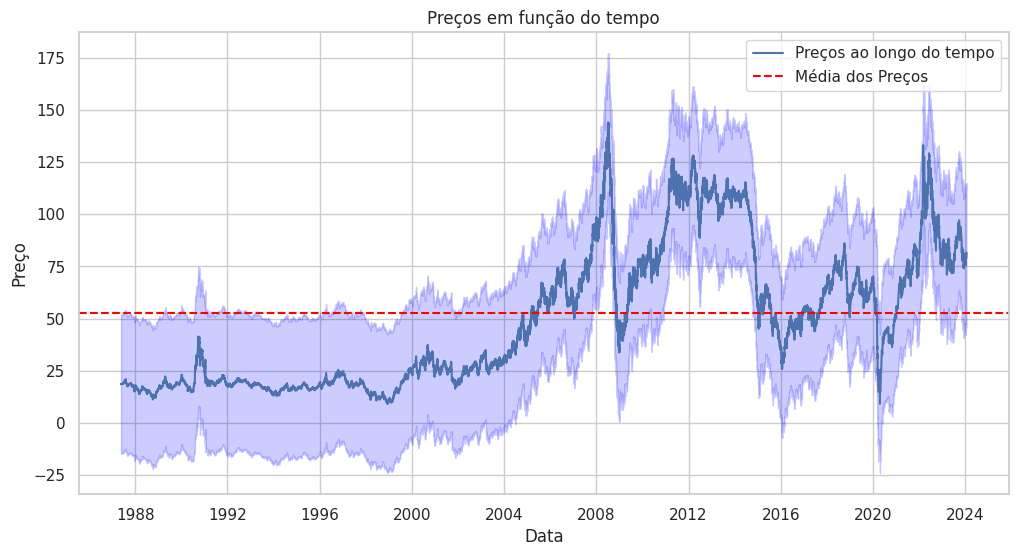

In [16]:
sns.set(style="whitegrid")
media = df['Preço'].mean()
desvio_padrao = df['Preço'].std()

plt.figure(figsize=(12, 6))

sns.lineplot(x='Data', y='Preço', data=df, label='Preços ao longo do tempo')

plt.fill_between(df['Data'], df['Preço'] - desvio_padrao, df['Preço'] + desvio_padrao, color='blue', alpha=0.2)

plt.axhline(y=media, color='red', linestyle='--', label='Média dos Preços')

plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Preços em função do tempo')
plt.legend()

plt.show()


A sombra representa o nosso desvio padrão em torno do comportamento do preço da commoditie.

#### <u>Medidas de Tendência central

In [17]:
round(df.describe(),2).T

,count,mean,std,min,25%,50%,75%,max
Preço,11092.0,52.8,33.23,9.1,20.41,47.9,75.75,143.95


#### Mediana

In [18]:
df['Preço'].median()

47.9

#### Média aparada

Aqui vamos avaliar o impacto de outliers para essa diferença entre a média e a mediana com a utilização da média aparada.

In [19]:
# Definindo a porcentagem de dados a serem aparados de cada extremidade
# Por exemplo, 0.1 significa aparar 10% dos dados de cada extremidade
proporcao_aparada = 0.1

# Calculando a média aparada
media_aparada = trim_mean(df['Preço'], proporcao_aparada)

print("Média Aparada:", media_aparada)


Média Aparada: 49.81552963714221


Vemos que realmente há o impacto de valores extremos no desvio entre a média e a mediana considerando apenas 10% do total dos dados. Vamos continuar avaliando os outliers para sabermos o impacto que esses extremos podem causar nos nossos modelos de machine learning, dada a possibilidade de sensibilidade desses.

#### <u>Medidas de Dispersão complementares

#### Boxplot e distribuição do tipo violino

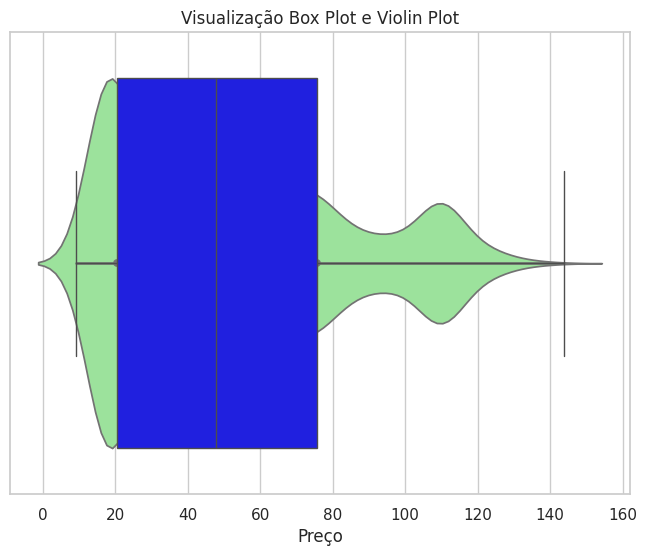

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
sns.violinplot(x='Preço', data=df, ax=ax, color='lightgreen')
sns.boxplot(x='Preço', data=df, ax=ax, whis=1.5, color='blue')
ax.set_title('Visualização Box Plot e Violin Plot')
plt.show()

#### Distribuição com histograma

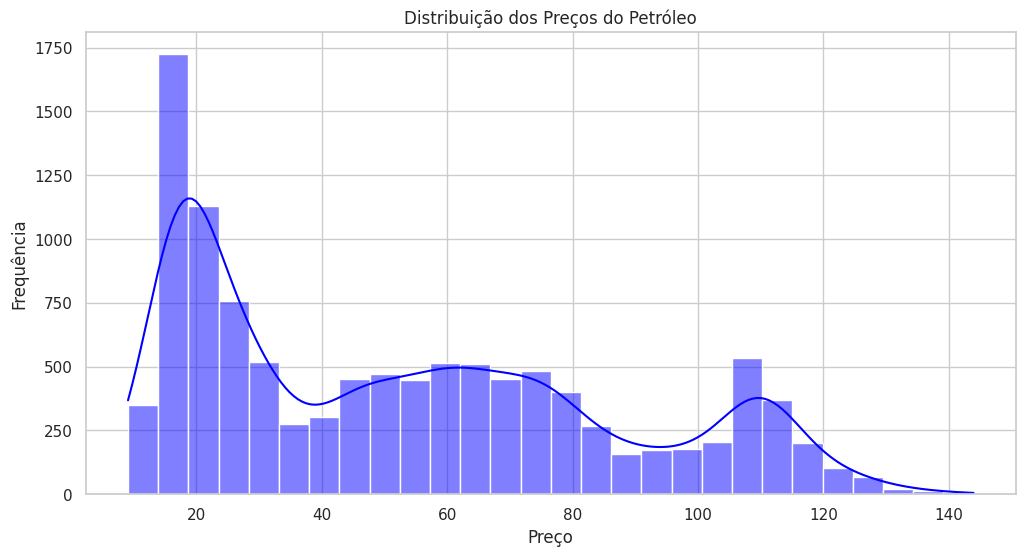

In [21]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(df['Preço'], kde=True, color='blue')
plt.title('Distribuição dos Preços do Petróleo')
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.show()

#### <u><b>Insights decorrentes da Análise Exploratória de Dados - AED

Na AED podemos ver o comportamento dos preços do petróleo, como a variância entre os valores mínimos e máximos, bem como o valor médio e a mediana com o intervalo de 50% interquartil.
<br><br>
O desvio padrão elevado nos mostra que temos uma alta volatilidade no preço dessa commoditie, o que implica em um maior risco para o mercado. Tal resultado implica na maior necessidade de planejamento orçamentário para possíveis elevações dos preços e também pode ser utilizado para a avaliação do custo de oportunidade ao investir nesse mercado em relação a outros mercados. Claro, entretanto, que sabemos que o nosso dataframe não apresenta outras features importantes que implicam nesse cenário, já que o preço de uma commoditie como o petróleo é diretamente correspondente a decisões de produtividade e com políticas ambientalistas. Tal característica significa que vamos utilizar aqui modelos de séries temporais para a nossa previsão de preços em linha ao objetivo do projeto em face da nossa série de eventos em função do tempo.
<br><br>
Na comparação entre as medidas da média e da mediana, vimos que há uma diferença significativa entre elas, o que remete a uma distribuição assimétrica dos nossos dados em torno da média, ou seja, não temos uma distribuição normal gaussiana. Uma das possibilidades é que tenhamos a presença de outliers que gerem esse impacto. Vamos avaliar em seguida.
<br><br>
O histograma dos preços do petróleo nos fornece uma visão da distribuição dos preços ao longo do tempo. A distribuição apresenta uma assimetria positiva (à direita), isso implica que a maior parte dos preços estão concentrados abaixo da média, mas existem alguns valores extremos mais altos que "puxam" a média para cima. Com base nisso, vamos a alguns insights relacionados a essa distribuição:
<br><br>
**Volatilidade do Mercado**: a distribuição indica que há períodos de alta volatilidade nos preços do petróleo. Esses picos podem estar relacionados a eventos específicos, como crises geopolíticas, mudanças na produção de petróleo, ou outros fatores do mercado;
<br><br>
**Riscos de Investimento**: Para investidores, a distribuição sinaliza um maior risco, pois há uma chance significativa de ocorrerem picos de preços. Essa informação é crucial para estratégias de "hedge" e para a tomada de decisões de investimento.
<br><br>
**Planejamento e Previsão**: Empresas que dependem do petróleo como matéria-prima podem usar essa informação para planejar e prever custos. A presença de valores extremos sugere a necessidade de um planejamento cuidadoso para lidar com possíveis aumentos súbitos nos preços.
<br><br>
**Análise de Tendências**: Identificar os períodos em que ocorreram os picos de preço pode levar a uma análise mais aprofundada sobre o que causou esses aumentos. Isso ajuda a prever futuras tendências de mercado ou a entender melhor os fatores que afetam os preços do petróleo.
<br><br>
**Estratégias de Compra**: O nosso entendimento sobre a distribuição dos preços pode nos ajudar a desenvolver estratégias de compra, como a compra de futuros para proteção contra picos de preços, a operação de hedge que citamos anteriormente.
<br><br>
**Impacto Econômico**: os impactos econômicos estão mais relacionados em setores sensíveis a esses preços, como transporte e manufatura.

### 2.4. Análise dos componentes temporais



**Análise de Séries Temporais**: Identificar padrões como sazonalidade, tendência e ruído. Gráficos como decomposição de séries temporais podem ser úteis como os pilares da nossa análise temporal. Assim, de forma sintética vamos elucidar abaixo o que vamos entender com cada um desses pilares:<br><br>

- Tendência: em termos gerais é a nossa direção, mesmo que considerando fractais e/ou desvios no curto prazo;<br>
- Sazonalidade: rocorrência das nossas oscilações; e<br>
- Resíduo: o que sobra da nossa série quando retiramos a nossa sazonalidade.

#### Definindo a minha coluna 'Data"como a coluna index do dataframe

In [22]:
df.set_index('Data', inplace=True )

In [23]:
df.head()

,Preço
Data,
2024-01-22,81.70
2024-01-19,80.71
2024-01-18,81.04
2024-01-17,78.88
2024-01-16,80.15


#### Parametrizando a frequência da série temporal para a avaliação dos pilares da série

<u>Frequência - MENSAL

Vimos que ao definirmos a frequência temos valores nulos preenchidos automaticamente pelo método e, para tal, utilizamos o método fillna com o parâmetro 'bfill', que define ao valor NaN o valor do próximo evento do dataframe. Essa é uma maneira para podermos gerar o seasonal_decompose, já que este não permite que utilizemos valores nulos no df.

In [24]:
df2 = df.asfreq('M').fillna(method='bfill')

In [25]:
df2

,Preço
Data,
1987-05-31,19.08
1987-06-30,19.08
1987-07-31,20.03
1987-08-31,18.63
1987-09-30,18.48
...,...
2023-08-31,87.29
2023-09-30,81.72
2023-10-31,81.72


In [26]:
df2.loc['2023-12-31'] = 81.72

In [27]:
df2.loc['2023-12-31']

Preço    81.72
Name: 2023-12-31 00:00:00, dtype: float64

In [28]:
df2.isna().sum()

Preço    0
dtype: int64

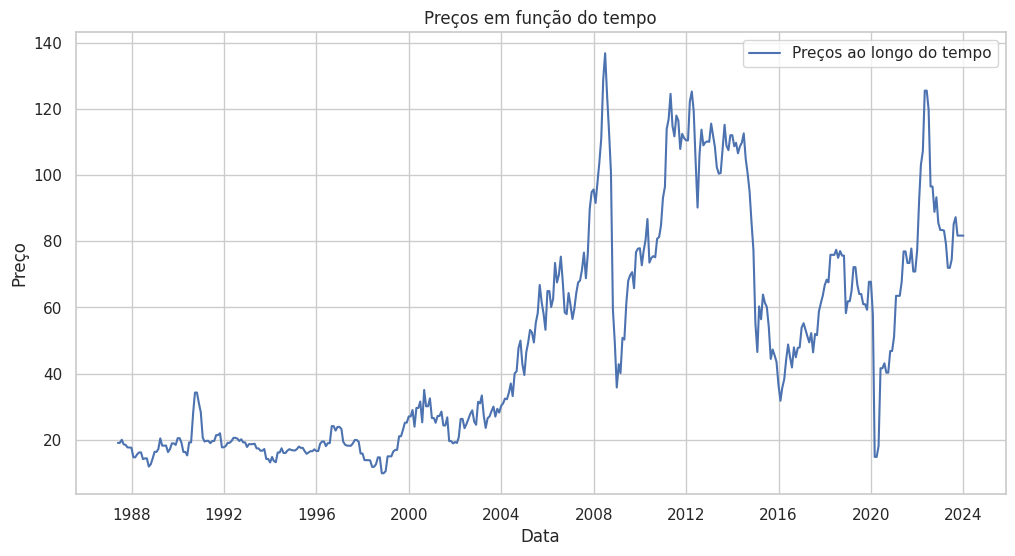

In [29]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x=df2.index, y='Preço', data=df2, label='Preços ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Preços em função do tempo')
plt.legend()

plt.show()

In [30]:
df.shape

(11092, 1)

<b>Frequência - DIÁRIA

In [31]:
df3 = df.asfreq('D').fillna(method='bfill')

In [32]:
df3

,Preço
Data,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-23,18.60
1987-05-24,18.60
...,...
2024-01-18,81.04
2024-01-19,80.71
2024-01-20,81.70


In [33]:
df3.shape

(13397, 1)

In [34]:
df3.isna().sum()

Preço    0
dtype: int64

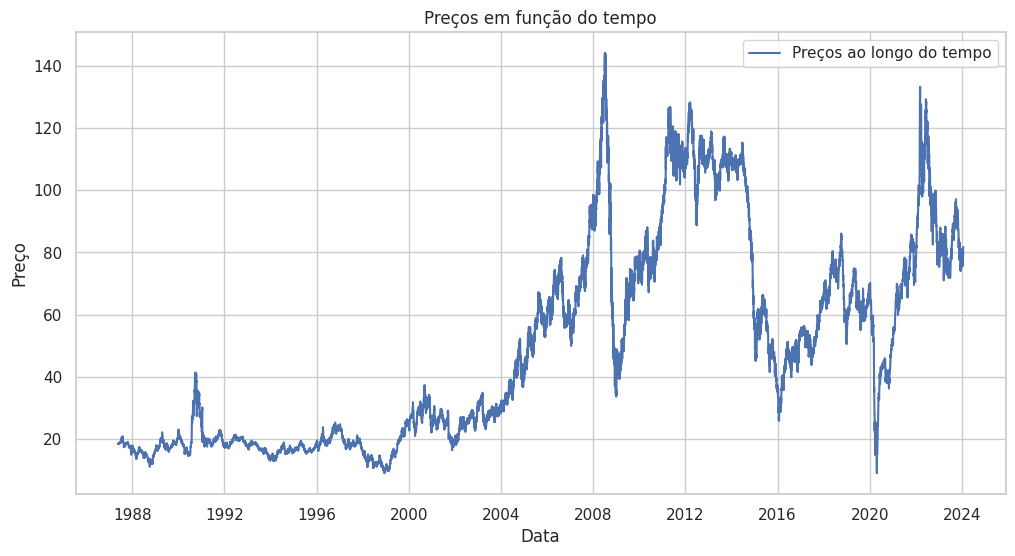

In [35]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x=df3.index, y='Preço', data=df3, label='Preços ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Preços em função do tempo')
plt.legend()

plt.show()

Para efeito de vizualização, vamos colocar as séries com frequências mensal e diária lado a lado:

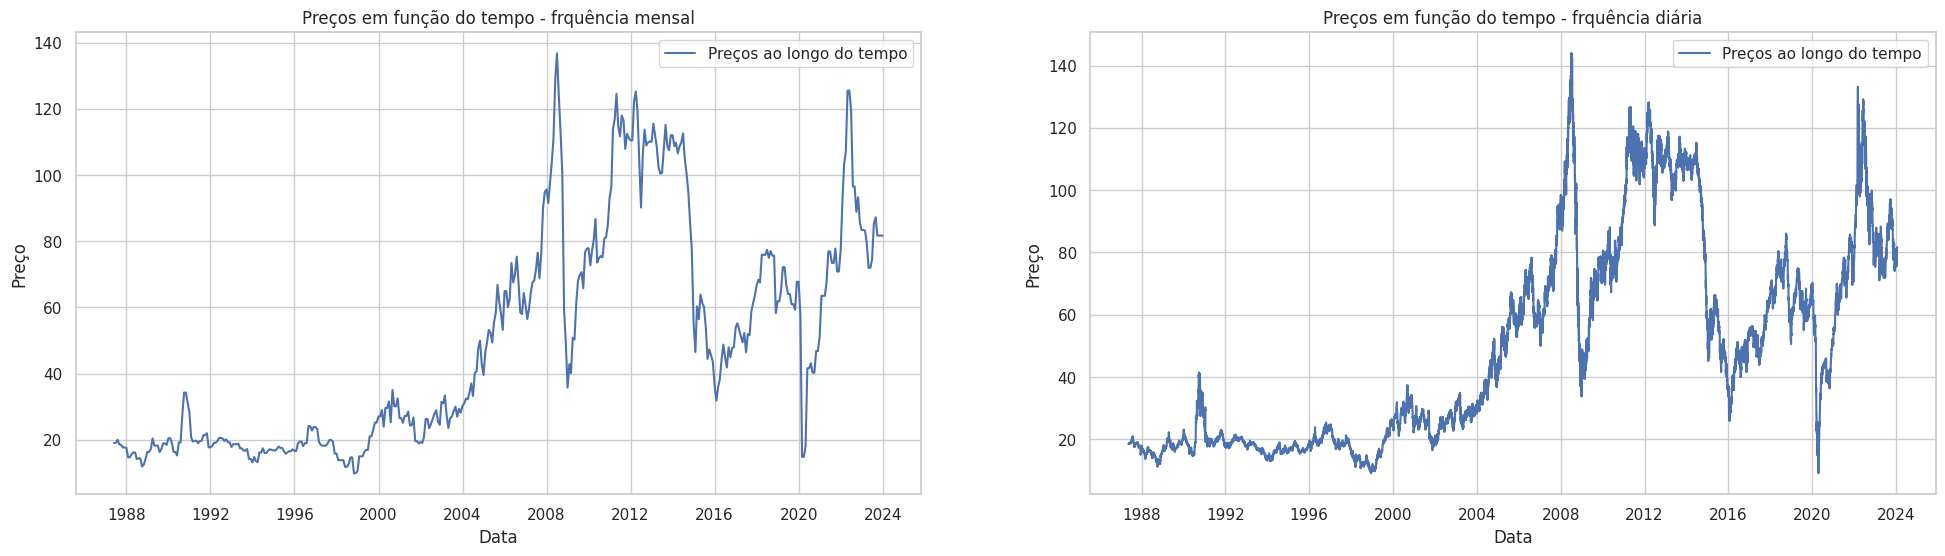

In [36]:
sns.set(style="whitegrid")

plt.figure(figsize=(24, 6))

# 1 linha, 2 colunas, primeiro gráfico
plt.subplot(1, 2, 1)

sns.lineplot(x=df2.index, y='Preço', data=df2, label='Preços ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Preços em função do tempo - frquência mensal')
plt.legend()

# Segundo subplot
plt.subplot(1, 2, 2)
sns.lineplot(x=df3.index, y='Preço', data=df3, label='Preços ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Preços em função do tempo - frquência diária')
plt.legend()

plt.show()

Vemos que o gráfico diário nos apresenta uma variabilidade muito maior em relação às fractais apresentadas no gráfico mensal. Pensando que estamos lidando com um modelo de machine learning, cujo modelo será treinado e que o seu desempenho para uma previsão mais assertiva se dá com a necessidade de um maior número de dados, vamos decidir utilizar o nosso dataframe 3, cuja frequência é diária e podemos alimentar o nosso modelo com uma maior variabilidade.

#### Decomposição da série temporal: Tendência, Sazonalidade e Ruído

In [37]:
resultados = seasonal_decompose(df3, model='multiplicative')


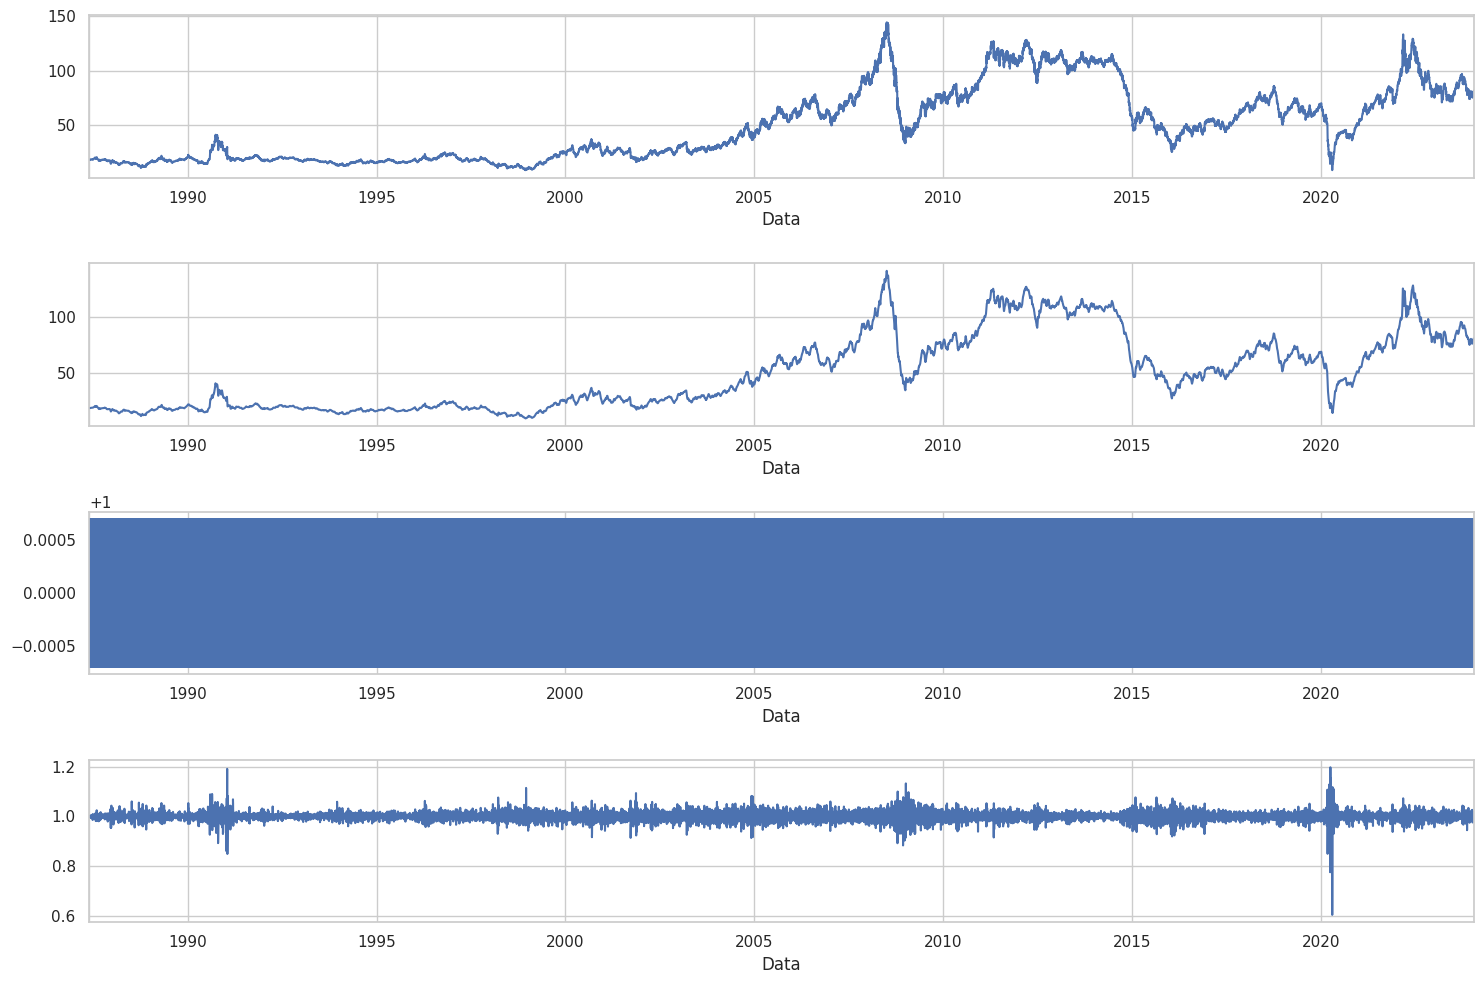

In [38]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

#### <b><u>Insights decorrentes da decomposição da série temporal

- <u>Dados originais</u>: Este é o gráfico da série temporal original. Aparentemente, mostra variações significativas ao longo do tempo com períodos de aumento e queda nos preços. Entretanto, estamos estudando uma commoditie que cuja variação está diretamente ligada a eventos específicos que causaram picos ou quedas no preço, como crises econômicas, mudanças políticas, ou desastres naturais que afetam a oferta e demanda de petróleo;<br><br>

- <u>Gráfico de Tendência</u>: O gráfico de tendência mostra uma visão suavizada, destacando as mudanças de longo prazo nos preços do petróleo Brent. Parece haver um aumento geral na tendência até cerca de 2008, seguido por uma relativa estabilidade e, depois, uma tendência de queda e aumento novamente após 2010 em face da crise causada falta de liquidez bancária gerada pela falta de critérios sólidos de concessão de crédito imobiliário, o que podemos sintetizar como subprime. Isso pode refletir mudanças de longo prazo na economia global, mudanças na produção de petróleo, ou políticas energéticas, bem como novas crises, como a causada pela Covid-19, ocorrida nos últimos anos, principalmente nos anos de 2019 a 2021 e as guerras entre a Rússia e Ucrânia e a guerra no mundo árabe; <br><br>

- <u>Gráfico Sazonal</u>: Primeiro cabe citar que entendemos sazonalidade como flutuações periódicas e previsíveis. O gráfico de sazonalidade aqui nos mostra que a sazonalidade é muito pequena quando comparada com a magnitude dos dados e variações absolutas; e<br><br>

- <u>Gráfico de Resíduos</u>: O gráfico de resíduos mostra o que resta depois de retirar a tendência e a sazonalidade dos dados. Este ruído pode conter informações aleatórias ou não capturadas pelos outros componentes. No nosso caso, os resíduos parecem ter alguma estrutura, com períodos de maior volatilidade, o que pode indicar informações adicionais que poderiam ser modeladas ou investigadas.


## **Verificação de Estacionaridade:**




Séries temporais devem ser estacionárias para a maioria das modelagens. Testes como o teste Dickey-Fuller aumentado podem ser usados para verificar a estacionariedade.

##### <b>ADF - Augmented Dickey Fuller</b>

###### H0 - Hipótese Nula (não é estacionária)
###### H1 - Hipótese Alternativa (rejeição da hipótese nula)

##### p -value = 0.05 (5%), então rejeitamos H0 com um nível de confiança de 95%

In [39]:
sns.set_style('darkgrid')

In [40]:
X = df3.Preço.values #transformando a nossa variável num array

In [41]:
result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -2.0314545641561494
P-Value: 0.27295389552077187
Valores críticos:
	1%: -3.430839635953766
	5%: -2.8617563959565815
	10%: -2.5668851826834835


A hipótese nula (H0) para o teste ADF é que a série temporal possui uma raiz unitária e, portanto, é não estacionária;<br>
O valor-p de 0.2666 é maior do que o nível de significância de 0.05 (5%). Isso significa que não temos evidências suficientes para rejeitar a hipótese nula com um nível de confiança de 95%. Em outras palavras, com base no valor-p, a série temporal parece ser **não estacionária**;<br>
O teste estatístico de -2.0464 é maior (em termos de valor absoluto) do que os valores críticos para os níveis de confiança de 1%, 5% e 10%. Isso reforça a conclusão de que não podemos rejeitar a hipótese nula.

**Cálculo da Média Móvel e Plotagem da Série Temporal e da Média Móvel** como testes adicionais à verificação de estacionaridade da série temporal

Visualizar a série temporal juntamente com sua média móvel. A média móvel suaviza a série temporal e ajuda a identificar tendências de longo prazo, eliminando flutuações de curto prazo. Isso pode ser particularmente útil para identificar se existe alguma tendência subjacente na série temporal, o que é uma consideração importante ao determinar se uma série é estacionária ou não.

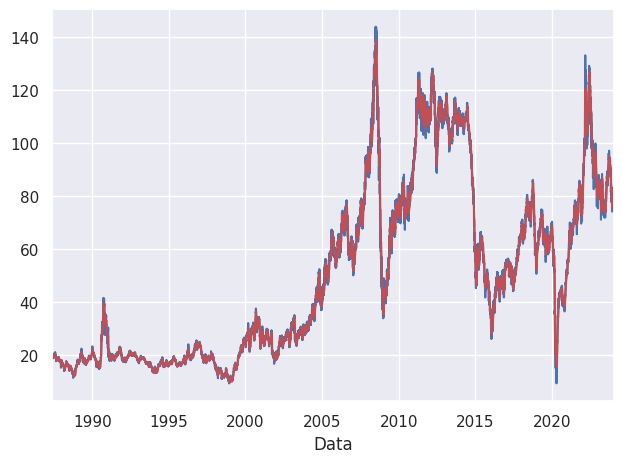

In [42]:
ma = df3.rolling(12).mean()

f, ax = plt.subplots()
df3.plot(ax=ax, legend=False)
ma.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

**Variação na média**: A linha da média móvel (em vermelho) não é constante ao longo do tempo. Ela mostra uma variação significativa, subindo e descendo em diferentes períodos. Isso é um indicativo de que a média da série temporal varia com o tempo.<br>
**Tendência**: A média móvel também parece capturar uma tendência de aumento nos preços ao longo do tempo, particularmente notável na subida para os picos em torno de 2008 e após 2010.<br>
**Variação na Amplitude**: Além disso, a amplitude das flutuações da série temporal parece mudar em diferentes períodos, o que pode sugerir mudanças na variância ao longo do tempo, entretanto, esse laventamento já fora realizado na própria análise exploratória de dados.
<br><br>
Os aspectos visuais reforçam a ideia de que a série temporal não é estacionária. Em séries estacionárias, esperamos que a média e a variância sejam aproximadamente constantes ao longo do tempo, e que não haja uma forma ou tendência clara visível na média móvel. A presença de tendências ou mudanças na variância é um sinal de não-estacionariedade, que está em linha com os resultados do nosso teste ADF, onde o valor-p não foi suficientemente baixo para rejeitar a hipótese nula de que a série tem uma raiz unitária (ou seja, é não estacionária).<br><br>
Com base nos resultados acima apresentados vamos realizar a transformação da nossa série em uma série logarítmica. A transformação logarítmica é uma técnica comum usada para estabilizar a variância em séries temporais, especialmente quando há flutuações significativas ou crescimento exponencial. Ela também pode ajudar a tornar as tendências mais lineares e, portanto, mais fáceis de modelar com técnicas estatísticas.

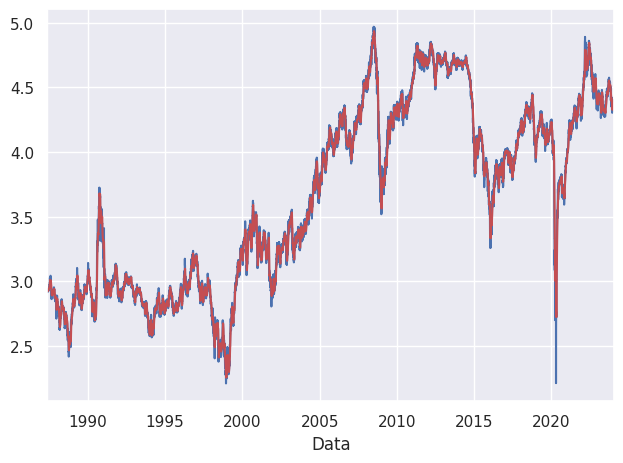

In [43]:
df_log = np.log(df3)
ma_log = df_log.rolling(12).mean()

f, ax = plt.subplots()
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

Conforme acima apresentado, para considerar uma série temporal como estacionária, queremos ver uma média móvel que permanece aproximadamente constante ao longo do tempo, sem padrões sistemáticos de subida ou descida. Ainda que a transformação logarítmica possa ter ajudado a estabilizar a variância, a presença de uma tendência sugere que a série ainda não é estacionária.

 Agora vamos analisar a estacionariedade da série temporal após a remoção da tendência. Ao plotar a série diferenciada juntamente com a média móvel e desvio padrão, podemos avaliar visualmente se a série se tornou mais estacionária.

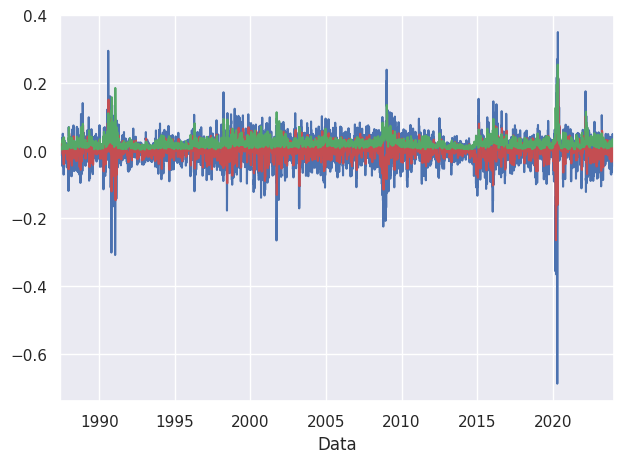

In [44]:
df_s = (df_log - ma_log).dropna()

ma_s = df_s.rolling(12).mean()

std = df_s.rolling(12).std()

f, ax = plt.subplots()
df_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

Com base no gráfico acima apresentado, a linha da média móvel (vermelha) parece estar oscilando em torno de zero sem uma direção de tendência clara, o que é um bom sinal para a estacionariedade.<br><br>
O desvio padrão móvel (verde) também parece relativamente constante ao longo do tempo, sem grandes variações, sugerindo que a volatilidade da série não está mudando com o tempo, o que também apoia a noção de estacionariedade.<br>
A série temporal ajustada (azul) não mostra padrões claros de tendência ou sazonalidade e oscila em torno da média móvel (vermelho), o que reforça a ideia de que a série pode ser estacionária.<br><br>
No entanto, ainda existem picos e vales, e algumas oscilações notáveis, especialmente um pico significativo próximo ao final da série. Estas podem ser outliers ou podem ser causadas por eventos específicos.Portanto, é apropriado realizar novamente um teste ADF, na série ajustada.


In [45]:
X_s = df_s.Preço.values
result_s = adfuller(X_s)

print("Teste ADF")
print(f"Teste Estatístico: {result_s[0]}")
print(f"P-Value: {result_s[1]}")
print("Valores críticos:")

for key, value in result_s[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -16.130284243343155
P-Value: 4.793479807922721e-29
Valores críticos:
	1%: -3.4308400395674528
	5%: -2.861756574320043
	10%: -2.5668852776248805


O teste estatístico está bem abaixo do valor crítico de 1%. Isso significa que você pode rejeitar a hipótese nula com mais de 99% de confiança, o que é uma indicação muito forte de que a série temporal é estacionária.<br>
O valor-p é praticamente zero, o que fornece evidências estatísticas muito fortes contra a hipótese nula. Isso reforça a conclusão de que a série temporal não possui uma raiz unitária e é estacionária.<br>
Dado que os valores críticos são significativamente mais altos que o valor do teste estatístico, essa diferença reforça ainda mais a rejeição da hipótese nula.<br>
Assim, com base no teste ADF, temos fortes evidências estatísticas de que a série temporal ajustada, após subtração da média móvel da série logarítmica, é estacionária. Isso sugere que qualquer tendência ou sazonalidade presente na série original foi removida com sucesso, e a série transformada pode ser considerada para análises adicionais e modelagem de previsão. Trabalhar com séries temporais estacionárias é uma prática padrão na previsão de séries temporais porque simplifica a modelagem, aumenta a precisão das previsões e garante que as propriedades estatísticas dos dados permaneçam consistentes ao longo do tempo. Isso é essencial para que os modelos de previsão sejam capazes de capturar a verdadeira natureza dos processos geradores dos dados.<br><br>Poderíamos tentar aumentar a nossa suavisação para garantir uma maior estacionaridade, mas nesse momento iremos aceitar a atual margem como suficiente para prosseguirmos com o nosso forecasting da série temporal.

## **2.5. Treinando os modelos e testando as performances**

####**Prophet**

In [46]:
df4 = df3.reset_index(drop=False)

In [47]:
df4 = df4.rename(columns={'Data':'ds', 'Preço':'y'})

In [48]:
df4.dtypes

ds    datetime64[ns]
y            float64
dtype: object

#### Separando em treino e teste

In [49]:
train_data = df4.sample(frac=0.8, random_state=0)
test_data = df4.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (10718, 2)
testing data size : (2679, 2)


#### Treinando o modelo

In [50]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=30, freq='D')
previsao = modelo.predict(dataFramefuture)
previsao.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpq667792p/mbq2fl8x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq667792p/5518fk_d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95563', 'data', 'file=/tmp/tmpq667792p/mbq2fl8x.json', 'init=/tmp/tmpq667792p/5518fk_d.json', 'output', 'file=/tmp/tmpq667792p/prophet_model8_70ldex/prophet_model-20240128203619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:36:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:36:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1987-05-21,17.357635,3.423129,29.595748,17.357635,17.357635,-0.373333,-0.373333,-0.373333,-1.863738,...,0.112819,0.112819,0.112819,1.377586,1.377586,1.377586,0.0,0.0,0.0,16.984302
1,1987-05-22,17.361804,2.795139,30.278574,17.361804,17.361804,-0.553813,-0.553813,-0.553813,-1.863738,...,-0.063565,-0.063565,-0.063565,1.373490,1.373490,1.373490,0.0,0.0,0.0,16.807991
2,1987-05-23,17.365972,4.772258,31.152677,17.365972,17.365972,-0.553110,-0.553110,-0.553110,-1.863738,...,-0.051002,-0.051002,-0.051002,1.361631,1.361631,1.361631,0.0,0.0,0.0,16.812863
3,1987-05-24,17.370141,4.091916,31.428671,17.370141,17.370141,-0.493286,-0.493286,-0.493286,-1.863738,...,0.028072,0.028072,0.028072,1.342380,1.342380,1.342380,0.0,0.0,0.0,16.876855
4,1987-05-25,17.374310,3.854316,30.387672,17.374310,17.374310,-0.534811,-0.534811,-0.534811,-1.863738,...,0.012634,0.012634,0.012634,1.316293,1.316293,1.316293,0.0,0.0,0.0,16.839499


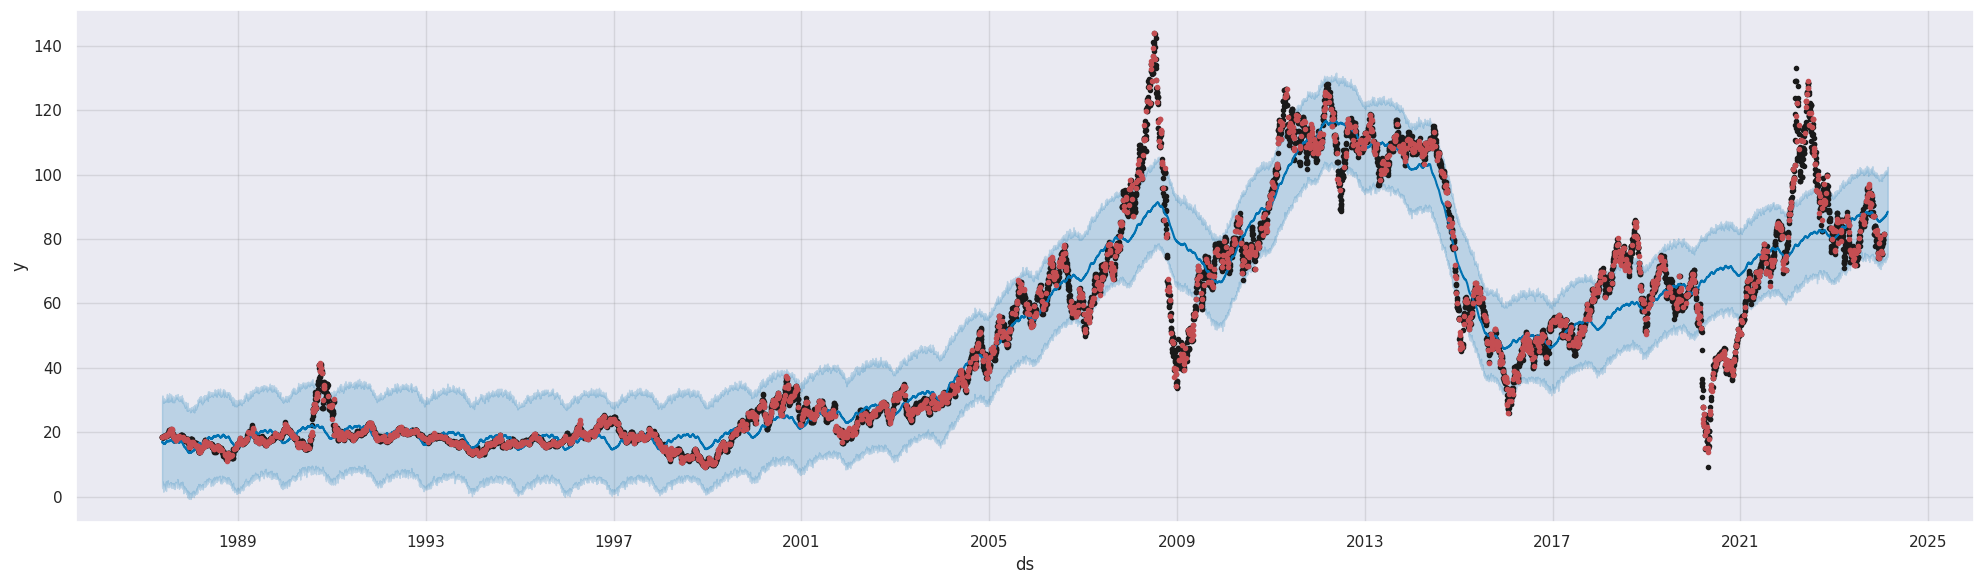

In [51]:
modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

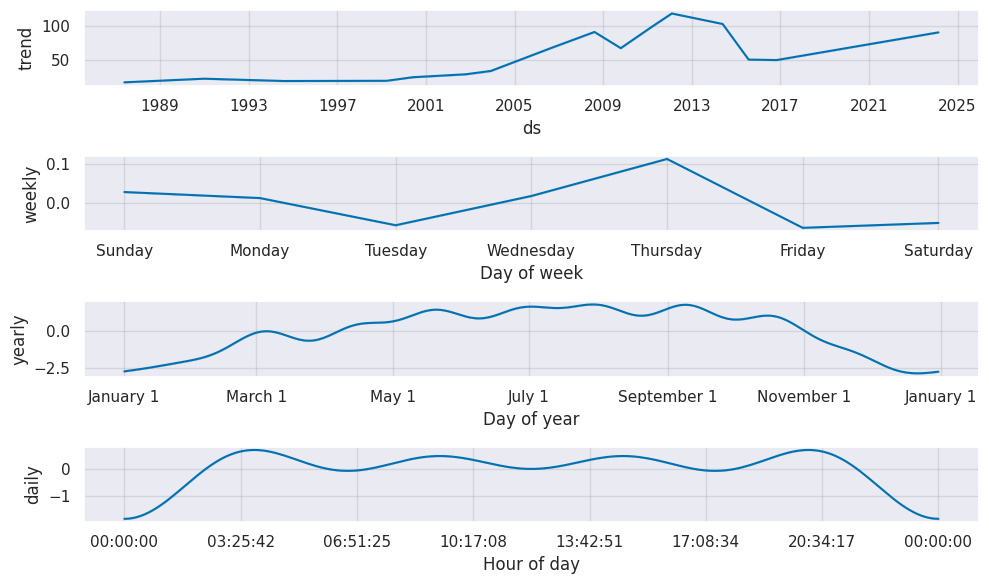

In [52]:
modelo.plot_components(previsao, figsize=(10,6));

**Adicionando Changepoints no modelo**

In [53]:
from prophet.plot import add_changepoints_to_plot

modelo_changepoints = Prophet(n_changepoints=5)
modelo_changepoints.fit(train_data)
dataFramefuture = modelo_changepoints.make_future_dataframe(periods=30, freq='D')
previsao_changepoints = modelo_changepoints.predict(dataFramefuture)
previsao_changepoints.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq667792p/kx1_mzy8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq667792p/61vbh06e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33393', 'data', 'file=/tmp/tmpq667792p/kx1_mzy8.json', 'init=/tmp/tmpq667792p/61vbh06e.json', 'output', 'file=/tmp/tmpq667792p/prophet_modelbkolvnqt/prophet_model-20240128203630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:36:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:36:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1987-05-21,18.439851,2.223278,38.468599,18.439851,18.439851,2.049590,2.049590,2.049590,0.242583,0.242583,0.242583,1.807007,1.807007,1.807007,0.0,0.0,0.0,20.489441
1,1987-05-22,18.439971,1.169839,39.588348,18.439971,18.439971,1.691186,1.691186,1.691186,-0.081149,-0.081149,-0.081149,1.772335,1.772335,1.772335,0.0,0.0,0.0,20.131157
2,1987-05-23,18.440091,2.867331,38.837666,18.440091,18.440091,1.666099,1.666099,1.666099,-0.059177,-0.059177,-0.059177,1.725276,1.725276,1.725276,0.0,0.0,0.0,20.106190
3,1987-05-24,18.440210,0.258111,38.550842,18.440210,18.440210,1.709989,1.709989,1.709989,0.043126,0.043126,0.043126,1.666863,1.666863,1.666863,0.0,0.0,0.0,20.150200
4,1987-05-25,18.440330,1.903864,38.304550,18.440330,18.440330,1.593179,1.593179,1.593179,-0.005247,-0.005247,-0.005247,1.598426,1.598426,1.598426,0.0,0.0,0.0,20.033509


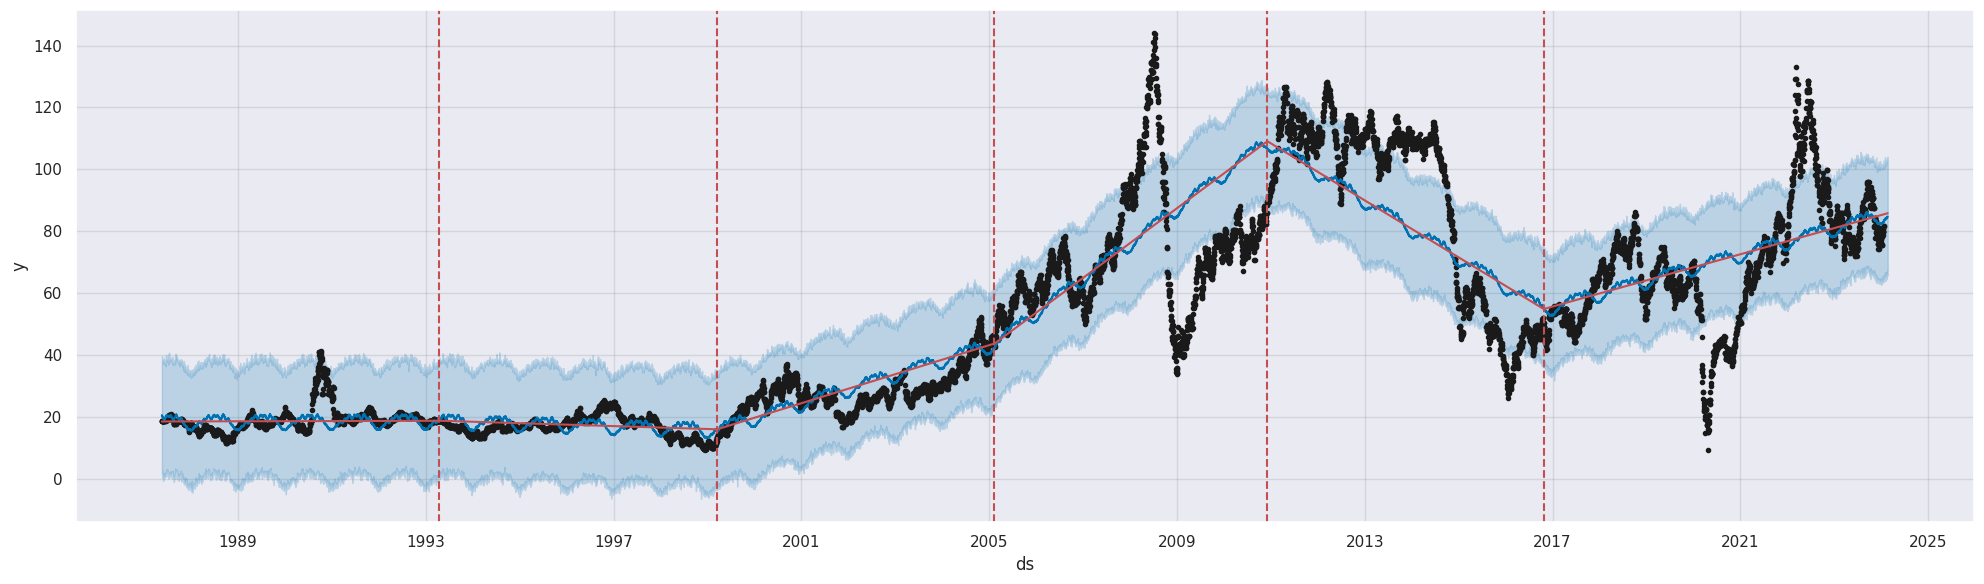

In [54]:
fig = modelo_changepoints.plot(previsao_changepoints, figsize=(20,6));
a = add_changepoints_to_plot(fig.gca(), modelo_changepoints, previsao_changepoints)

**Testando a performance - MAPE**

In [55]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 15.58%


##Cross validation
Para concluir o modelo do Prophet, tentei fazer a validação cruzada para testar dados que nunca foram vistos pelo modelo antes.

Observe que no resultado da validação cruzada temos os valores de yhat, yhat_lower, yhat_upper e o ponto de corte. O objetivo da validação cruzada é medir o erro de predição, selecionando assim pontos de corte e para cada um desses pontos o modelo é ajustado utilizando dados apenas até aquele ponto de corte.

In [56]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(modelo, initial='730 days', period='180 days', horizon = '365 days')

INFO:prophet:Making 69 forecasts with cutoffs between 1989-07-19 00:00:00 and 2023-01-22 00:00:00


  0%|          | 0/69 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpq667792p/22wlwgez.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq667792p/k60qmubu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73424', 'data', 'file=/tmp/tmpq667792p/22wlwgez.json', 'init=/tmp/tmpq667792p/k60qmubu.json', 'output', 'file=/tmp/tmpq667792p/prophet_modelujf2mmov/prophet_model-20240128203634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:36:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:36:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq667792p/202nsiaq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq667792p/krtgnwdp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [57]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1989-07-20,18.038812,17.295412,18.730615,17.98,1989-07-19
1,1989-07-21,17.994219,17.325759,18.682573,17.83,1989-07-19
2,1989-07-22,17.947663,17.276622,18.684654,17.30,1989-07-19
3,1989-07-24,18.003124,17.309158,18.701230,17.30,1989-07-19
4,1989-07-26,17.994958,17.325944,18.647972,16.50,1989-07-19


In [58]:
df_cv['cutoff'].unique()

array(['1989-07-19T00:00:00.000000000', '1990-01-15T00:00:00.000000000',
       '1990-07-14T00:00:00.000000000', '1991-01-10T00:00:00.000000000',
       '1991-07-09T00:00:00.000000000', '1992-01-05T00:00:00.000000000',
       '1992-07-03T00:00:00.000000000', '1992-12-30T00:00:00.000000000',
       '1993-06-28T00:00:00.000000000', '1993-12-25T00:00:00.000000000',
       '1994-06-23T00:00:00.000000000', '1994-12-20T00:00:00.000000000',
       '1995-06-18T00:00:00.000000000', '1995-12-15T00:00:00.000000000',
       '1996-06-12T00:00:00.000000000', '1996-12-09T00:00:00.000000000',
       '1997-06-07T00:00:00.000000000', '1997-12-04T00:00:00.000000000',
       '1998-06-02T00:00:00.000000000', '1998-11-29T00:00:00.000000000',
       '1999-05-28T00:00:00.000000000', '1999-11-24T00:00:00.000000000',
       '2000-05-22T00:00:00.000000000', '2000-11-18T00:00:00.000000000',
       '2001-05-17T00:00:00.000000000', '2001-11-13T00:00:00.000000000',
       '2002-05-12T00:00:00.000000000', '2002-11-08

In [59]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,316.823375,17.799533,11.939318,0.238516,0.165612,0.231512,0.379515
1,38 days,321.110810,17.919565,12.000857,0.240065,0.165728,0.232907,0.378681
2,39 days,325.181689,18.032795,12.070346,0.242129,0.166830,0.234901,0.376626
3,40 days,330.026983,18.166645,12.146698,0.243809,0.165935,0.236420,0.376173
4,41 days,332.106618,18.223793,12.168908,0.243863,0.165387,0.236905,0.376704
...,...,...,...,...,...,...,...,...
324,361 days,770.293520,27.754162,19.426420,0.428449,0.270335,0.409865,0.419913
325,362 days,774.142133,27.823410,19.494441,0.429124,0.273044,0.409917,0.417850
326,363 days,772.873076,27.800595,19.490818,0.428515,0.272295,0.410334,0.418939
327,364 days,773.652879,27.814616,19.504344,0.429938,0.274280,0.411477,0.420204


####**LSTM**

In [60]:
df3.head()

,Preço
Data,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-23,18.60
1987-05-24,18.60


In [61]:
df3 = df3.reset_index(drop=False)

In [62]:
close_data = df3['Preço'].values
close_data = close_data.reshape(-1,1) #transformar em array

**Normalizando os dados**

In [63]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

**Separação da base de treino e teste:**

In [64]:
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df3['Data'][:split]
date_test = df3['Data'][split:]

print(len(close_train))
print(len(close_test))

10717
2680


In [65]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 10

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [66]:
from tensorflow.keras.metrics import MeanSquaredError

np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
536/536 [==============================] - 3s 4ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 2/20
536/536 [==============================] - 2s 4ms/step - loss: 4.8223e-04 - mean_squared_error: 4.8223e-04
Epoch 3/20
536/536 [==============================] - 2s 4ms/step - loss: 3.6708e-04 - mean_squared_error: 3.6708e-04
Epoch 4/20
536/536 [==============================] - 3s 5ms/step - loss: 5.0733e-04 - mean_squared_error: 5.0733e-04
Epoch 5/20
536/536 [==============================] - 2s 4ms/step - loss: 2.6506e-04 - mean_squared_error: 2.6506e-04
Epoch 6/20
536/536 [==============================] - 2s 4ms/step - loss: 2.3629e-04 - mean_squared_error: 2.3629e-04
Epoch 7/20
536/536 [==============================] - 2s 5ms/step - loss: 2.0658e-04 - mean_squared_error: 2.0658e-04
Epoch 8/20
536/536 [==============================] - 3s 5ms/step - loss: 1.8958e-04 - mean_squared_error: 1.8958e-04
Epoch 9/20
536/536 [==============================] - 2s 4ms/ste

In [67]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio", mse[0])

2670/2670 [==============================] - 5s 2ms/step - loss: 1.6141e-04 - mean_squared_error: 1.6141e-04
Erro Quadrático Médio 0.00016140926163643599


In [68]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f'MAPE: {mape:.4f}')

2670/2670 [==============================] - 6s 2ms/step
MAPE: 4.6063


In [69]:
#O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.012704694472376578


O RMSE fornece uma métrica de erro na mesma unidade que a variável alvo (nesse caso, o preço de fechamento). Portanto significa que, em média, as previsões do modelo estão desviando em torno de 0.013 unidades da variável de destino. Quanto menor o RMSE, melhor é o desempenho do modelo em termos de previsões de regressão.

In [70]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições do Preço do Barril",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Preço"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

2670/2670 [==============================] - 6s 2ms/step


###**Validando com suavização da série temporal**

In [71]:
df3.head()

,Data,Preço
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-23,18.60
4,1987-05-24,18.60


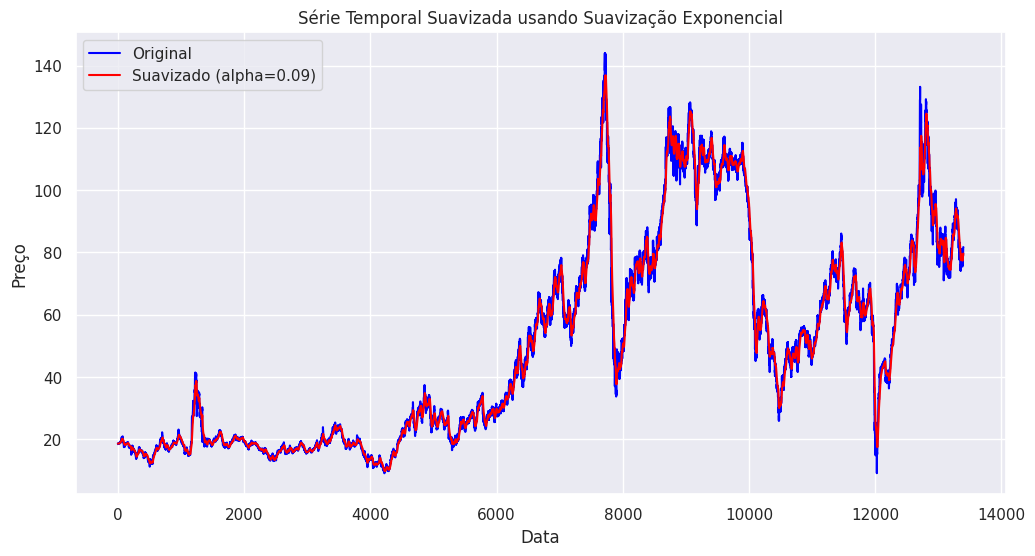

In [72]:
# Suazivando a série temporal
# Aplicando suavização exponencial
alpha = 0.09   # Fator de suavização
# O parâmetro alpha na suavização exponencial controla a taxa de decaimento dos pesos atribuídos às observações passadas.
# Determina o quão rapidamente o impacto das observações antigas diminui à medida que você avança no tempo.

df3['Smoothed_Close'] = df3['Preço'].ewm(alpha=alpha, adjust=False).mean()

# Visualizando os resultados
plt.figure(figsize=(12, 6))
plt.plot(df3.index, df3['Preço'], label='Original', color='blue')
plt.plot(df3.index, df3['Smoothed_Close'], label=f'Suavizado (alpha={alpha})', color='red')
plt.title('Série Temporal Suavizada usando Suavização Exponencial')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

In [73]:
# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df3['Smoothed_Close'] )
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.2922919745770027
p-value: 0.17446601583188825
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -2.2922919745770027
Valor-p: 0.17446601583188825
Valores Críticos:
   1%: -3.4308397459642745
   5%: -2.861756444572019
   10%: -2.5668852085610787


In [74]:
df3.drop(columns=['Preço'], inplace=True)
df3.head()

,Data,Smoothed_Close
0,1987-05-20,18.630000
1,1987-05-21,18.613800
2,1987-05-22,18.608058
3,1987-05-23,18.607333
4,1987-05-24,18.606673


In [75]:
close_data = df3['Smoothed_Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

In [76]:
close_data

array([[0.0697213 ],
       [0.06959376],
       [0.06954855],
       ...,
       [0.54671131],
       [0.54847075],
       [0.55007183]])

In [77]:
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df3['Data'][:split]
date_test = df3['Data'][split:]

print(len(close_train))
print(len(close_test))

10717
2680


In [78]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 5

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [79]:
np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=[MeanSquaredError()])

num_epochs = 100
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/100
536/536 [==============================] - 3s 3ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 2/100
536/536 [==============================] - 2s 3ms/step - loss: 6.6818e-05 - mean_squared_error: 6.6818e-05
Epoch 3/100
536/536 [==============================] - 2s 3ms/step - loss: 6.2777e-05 - mean_squared_error: 6.2777e-05
Epoch 4/100
536/536 [==============================] - 2s 3ms/step - loss: 1.2502e-04 - mean_squared_error: 1.2502e-04
Epoch 5/100
536/536 [==============================] - 2s 3ms/step - loss: 1.4253e-04 - mean_squared_error: 1.4253e-04
Epoch 6/100
536/536 [==============================] - 2s 3ms/step - loss: 1.4064e-04 - mean_squared_error: 1.4064e-04
Epoch 7/100
536/536 [==============================] - 1s 3ms/step - loss: 7.0807e-05 - mean_squared_error: 7.0807e-05
Epoch 8/100
536/536 [==============================] - 2s 3ms/step - loss: 1.5413e-04 - mean_squared_error: 1.5413e-04
Epoch 9/100
536/536 [==============================] - 2

In [80]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f"MAPE: {mape:.2f}%")

2675/2675 [==============================] - 4s 2ms/step
MAPE: 1.64%


In [81]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio:", mse[0])

2675/2675 [==============================] - 5s 2ms/step - loss: 1.1368e-05 - mean_squared_error: 1.1368e-05
Erro Quadrático Médio: 1.1368124432920013e-05


In [82]:
# O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.0033716649348534047


In [83]:
import joblib

###Salvando o modelo LSMT

In [84]:
joblib.dump(model, 'modelo_lsmt')

['modelo_lsmt']

Plotando os resultados! 📈

In [85]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições do Preço do barril de Petróleo",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

2675/2675 [==============================] - 4s 2ms/step


##**Realizando o Forecasting**

Agora chegou o momento de prever o futuro!

Vamos criar uma função para prever o futuro, vamos passar como parametro um número X de dias e a ideia dessa função é excutar o predict do modelo para nos retornar os dias futuros.

In [86]:
close_data = close_data.reshape((-1))

# Função para prever os próximos 'num_prediction' pontos da série temporal
# Utiliza o modelo treinado para prever cada ponto sequencialmente
# A cada iteração, adiciona a previsão à lista 'prediction_list'

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]

    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]

    return prediction_list

# Função para gerar as datas dos próximos 'num_prediction' dias
# Assume que o DataFrame 'df' possui uma coluna 'Date' contendo as datas

def predict_dates(num_prediction):
    last_date = df3['Data'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 15 #definição dos próximos dias
forecast = predict(num_prediction, model) #resultado de novos dias
forecast_dates = predict_dates(num_prediction)

1/1 [==============================] - 0s 15ms/step


In [87]:
trace1 = go.Scatter(
    x = date_test,
    y = close_test,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Prediction'
)
layout = go.Layout(
    title = "Forecast preço do barril",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

###**Organizando os dados em um dataframe**

In [88]:
df = pd.DataFrame(df3)
df_past = df3[['Data','Smoothed_Close']]
df_past.rename(columns={'Smoothed_Close': 'Actual'}, inplace=True)         #criando nome das colunas
df_past['Data'] = pd.to_datetime(df_past['Data'])                          #configurando para datatime
df_past['Forecast'] = np.nan                                               #Preenchendo com NAs
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
df_past.head(3)

<ipython-input-88-9f2a80509f8c>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Data,Actual,Forecast
0,1987-05-20,18.630000,NaN
1,1987-05-21,18.613800,NaN
2,1987-05-22,18.608058,NaN


In [89]:
# Faz a transformação inversa das predições
forecast = forecast.reshape(-1, 1) #reshape para array
forecast = scaler.inverse_transform(forecast)

In [91]:
df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = forecast_dates
df_future['Forecast'] = forecast.flatten()
df_future['Actual'] = np.nan
df_future.head()

,Date,Actual,Forecast
0,2024-01-22,NaN,79.643719
1,2024-01-23,NaN,80.092343
2,2024-01-24,NaN,80.546826
3,2024-01-25,NaN,81.037997
4,2024-01-26,NaN,81.548891


In [92]:
df_future.tail()

,Date,Actual,Forecast
11,2024-02-02,NaN,85.310198
12,2024-02-03,NaN,85.854692
13,2024-02-04,NaN,86.399678
14,2024-02-05,NaN,86.945058
15,2024-02-06,NaN,87.490702


In [93]:
# Concatenando os DataFrames usando concat
frames = [df_past, df_future]
results = pd.concat(frames, ignore_index=True).set_index('Data')
results.head()

,Actual,Forecast,Date
Data,,,
1987-05-20,18.630000,NaN,NaT
1987-05-21,18.613800,NaN,NaT
1987-05-22,18.608058,NaN,NaT
1987-05-23,18.607333,NaN,NaT
1987-05-24,18.606673,NaN,NaT


In [94]:
results2023 =  results.loc['2023-01-01':]

In [95]:
plot_data = [
    go.Scatter(
        x=results2023.index,
        y=results2023['Actual'],
        name='actual'
    ),
    go.Scatter(
        x=results2023.index,
        y=results2023['Forecast'],
        name='prediction'
    )
]

plot_layout = go.Layout(
        title='Forecast barril'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()

import plotly as ply
ply.offline.plot(fig)

'temp-plot.html'